In [3]:
import pandas as pd
import numpy as np
import requests
from zipfile import ZipFile
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold,train_test_split

In [4]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False

# **좌석 조건에 따른 시각화 그래프**

In [109]:
file_path = "C:/Users/whileduck/Desktop/빈좌석"
pattern = '/*.csv'

full_path = file_path + pattern

file_list = glob(full_path)

dataframe_dict = {}

for file in file_list:
    
    key = file.split('\\')[1].split('_')[0] # key 저장
    
    dataframe_dict[key] = pd.read_csv(file, low_memory = False)

print(dataframe_dict.keys())

dict_keys(['가족극', '교향곡', '기타', '독주', '복합장르', '성악', '실내악', '오페라', '재즈', '콘서트', '크로스오버', '클래식', '합창'])


# **프로토타입 생성하기**

* 각 좌석별 할인율을 포함하지 않은 원가격이 필요하다. 좌석별 할인율은 독립적일 것이기 때문이다.
* 하지만 현재 각 좌석별 할인율을 포함하지 않은 원가격이 없기 때문에 우선 할인율을 포함한 가격을 가지고 프로토타입을 만들고 추후 수정하도록 함 

In [111]:
df = dataframe_dict['클래식']

In [230]:
class seat_scatter:
    
    def __init__(self,data):
        
        self.df = data 
        
    def devide_condition(self,cond_key,cond_value, detail_cond = None):
        '''
        condition 에 따라서 데이터 프레임을 다르게 나눠 scatterplot 을 그리기 위함입니다
        '''
        
        condition = self.df[cond_key] == cond_value # condition 에 대한 것만 다룰 것인지
        self.cond_df = self.df[condition]
        self.cond_key  = cond_key
        self.cond_value = cond_value
        
        self.purchase_df = self.cond_df[self.cond_df['예매여부'] == 1] # cond_df 는 예매된 좌석에 대해서만 다루자
        self.no_purchase = self.cond_df[self.cond_df['예매여부'] == 0]
        
        self.detail_cond = detail_cond 
                
        
        if detail_cond is not None: # 만약 detail_cond 가 존재한다면 # hue 와 같은 역할
            self.detail_cond_type = self.cond_df[detail_cond].dtype    
            if self.cond_df[detail_cond].dtype == 'O': #범주형 변수라면
                
                self.unique_values = self.purchase_df[detail_cond].unique()
                
                cmap = plt.get_cmap('Paired', len(self.unique_values))
                
                self.color_dict = {var : cmap(i) for i,var in enumerate(self.unique_values)}
                
                self.colors = self.purchase_df[detail_cond].map(self.color_dict)
                
            else: # 수치형 변수라면 
                
                cmap = plt.get_cmap('YlOrRd')
                
                vmin = self.purchase_df[detail_cond].min()
                vmax = self.purchase_df[detail_cond].max()
                
                norm = mcolors.Normalize(vmin = vmin, vmax = vmax)
                
                self.colors = cmap(norm(self.purchase_df[detail_cond]))
                self.cbar = ScalarMappable(cmap = cmap,norm = norm)
                
        else:
            self.colors = self.cond_df['예매여부'].map({0:'grey',1:'blue'})
                
                
    def condition_scatter(self):
        
        fig,ax = plt.subplots(figsize = (10,10), subplot_kw = {'projection':'3d'})
        
        if self.detail_cond is not None:
            
            if self.detail_cond_type == 'O':
                # 범주형 변수일 때는 범주를 달자        
                self.handles = [plt.Line2D([0], [0], marker='o', color='w', label = var,
                                        markerfacecolor = self.color_dict[var]) for var in self.unique_values]
                self.handles.append(plt.Line2D([0], [0], marker='o', color='w', label = '예매안됨',
                                        markerfacecolor = 'grey'))

                ax.legend(handles = self.handles, bbox_to_anchor = (1.5,1))
                
                
            else:
                # 수치형 변수일 때는 cbar 를 달자 
                cbar = fig.colorbar(self.cbar, shrink = 1.2)
                cbar.set_label(self.detail_cond)
                cbar.ax.set_position([0.95,0.3,0.3,0.3])

        else:
            self.handles = [plt.Line2D([0], [0], marker='o', color='w', label = '예매됨',
                                    markerfacecolor='blue')]
            self.handles.append(plt.Line2D([0], [0], marker='o', color='w', label = '예매안됨',
                                    markerfacecolor= 'grey'))
            
            self.colors = 'blue'
            
            ax.legend(handles = self.handles, bbox_to_anchor = (1.5,1))

        
        
        ax.scatter(data = self.purchase_df, # 예매되고 조건에 따른 scatterplot
            xs = 'X',
            ys = 'Y',
            zs = 'Z',
            c = self.colors)
        
        ax.scatter(data = self.no_purchase, # 예매되지 않고 조건에 따른 scatterplot
            xs = 'X',
            ys = 'Y',
            zs = 'Z',
            c = 'grey')
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        ax.set_box_aspect([3,3,1])
        ax.set_title(f'{self.cond_key} : {self.cond_value}', fontsize = 20)
        
        
        

In [231]:
scatter_method = seat_scatter(df)

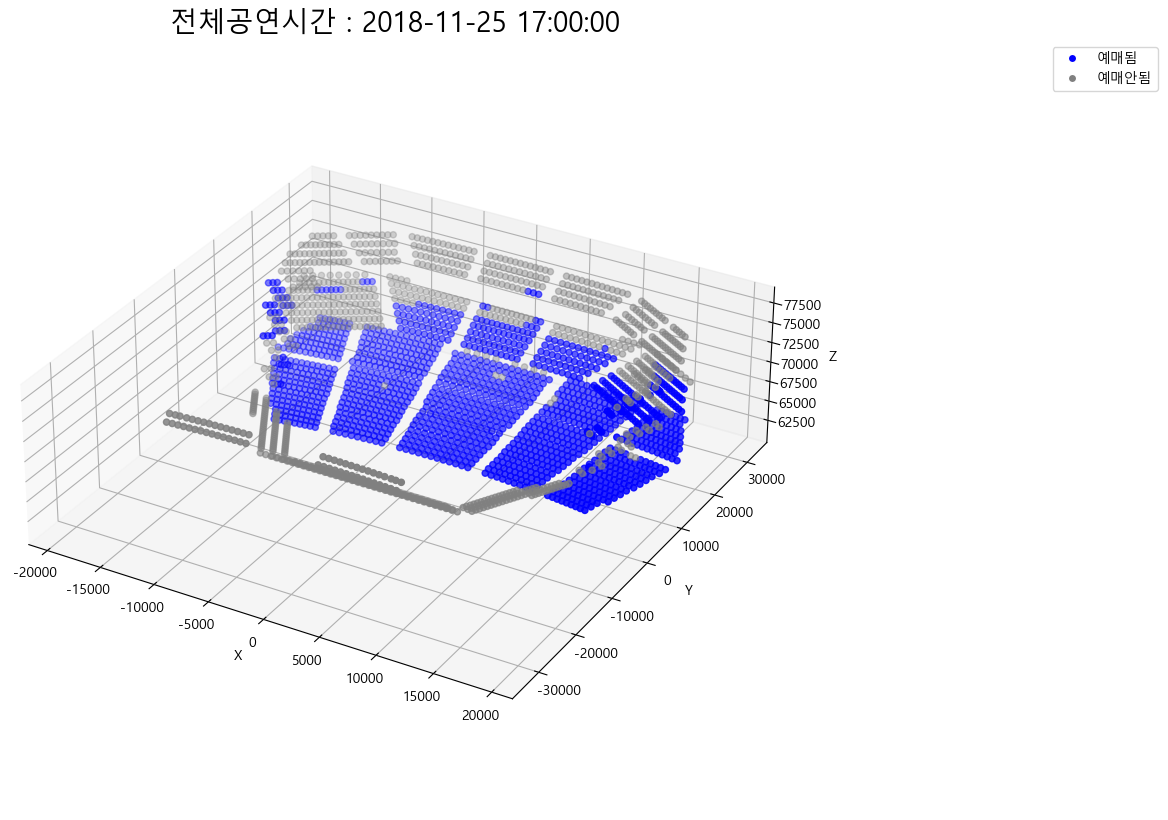

In [232]:
# 1. 특정 일자, 예매 여부에 따른 scatterplot 그리기

cond_key = '전체공연시간'
cond_value = df['전체공연시간'].unique()[0]

scatter_method.devide_condition(cond_key = cond_key, cond_value = cond_value)

scatter_method.condition_scatter()

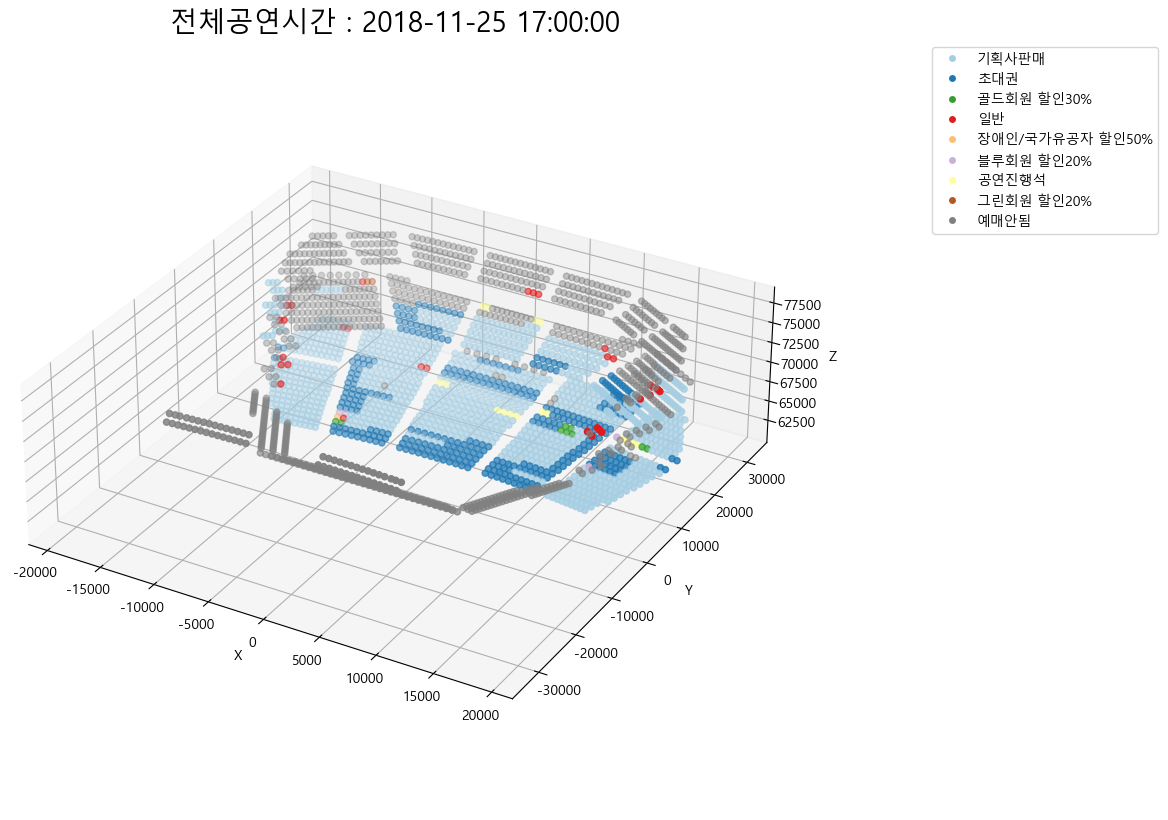

In [225]:
# 2. 특정 일자, 예매 여부 및 범주형 변수에 따른

cond_key = '전체공연시간'
cond_value = df['전체공연시간'].unique()[0]

scatter_method.devide_condition(cond_key = cond_key, cond_value = cond_value, detail_cond = 'discount_type')

scatter_method.condition_scatter()

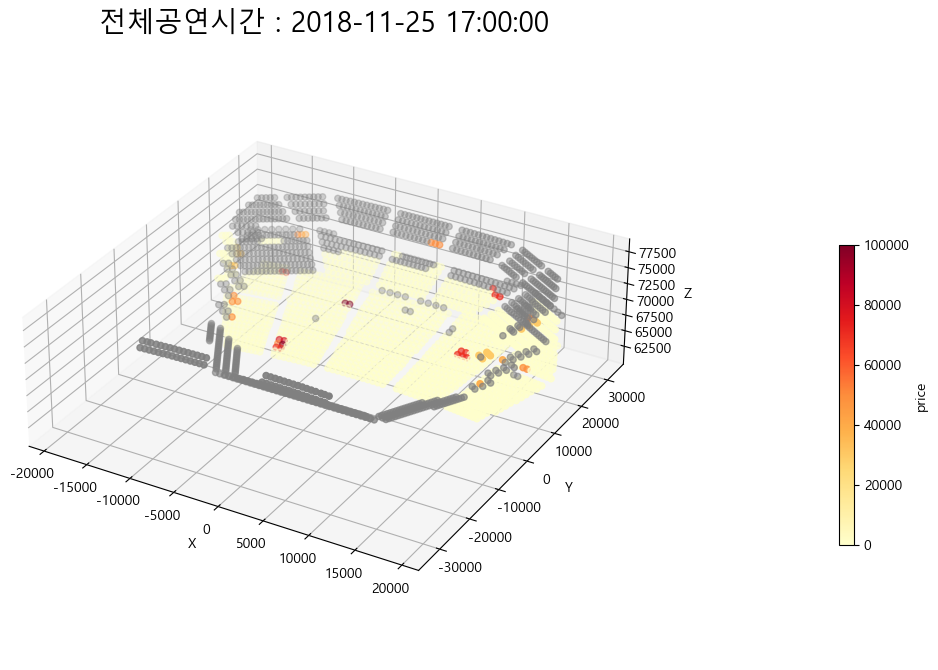

In [226]:
# 3. 특정 일자, 예매 여부 및 수치형 변수에 따른

cond_key = '전체공연시간'
cond_value = df['전체공연시간'].unique()[0]

scatter_method.devide_condition(cond_key = cond_key, cond_value = cond_value, detail_cond = 'price')

scatter_method.condition_scatter()